# Table of Contents
 <p><div class="lev1"><a href="#Login"><span class="toc-item-num">1&nbsp;&nbsp;</span>Login</a></div><div class="lev1"><a href="#Get-Machines-and-Users"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get Machines and Users</a></div><div class="lev1"><a href="#Plotting-code"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plotting code</a></div>

In [3]:
import sys
import os
import json
import time
import getpass
import pymongo
import datetime
import getpass
import numpy as np


#mpl for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib as mpl

# Login

In [4]:
mongo_client = pymongo.MongoClient(host='localhost', port=27018)
mongo_client['admin'].authenticate('admin',getpass.getpass('Please enter a password: '))

x = mongo_client['data']['machine_list'].find()
machines = []
for x_i in x:
    machines.append(x_i['machine'])

Please enter a password: ········


# Get Machines and Users

In [47]:
x = mongo_client['data']['machine_list'].find()
machines = []
for x_i in x:
    machines.append(x_i['machine'])

x = mongo_client['data']['user_list'].find()
users = []
for x_i in x:
    users.append(x_i['user'])

In [114]:
start_date = datetime.datetime(2016, 11, 9)
#end_date = datetime.datetime(2016, 10, 27)
end_date = datetime.datetime.now()
machine = 'einhorn'

In [115]:
data = list(mongo_client['data']['load_info'].find({'machine' : machine, 'date' : {'$gt' : start_date, '$lt' : end_date}}).sort('date', pymongo.DESCENDING))

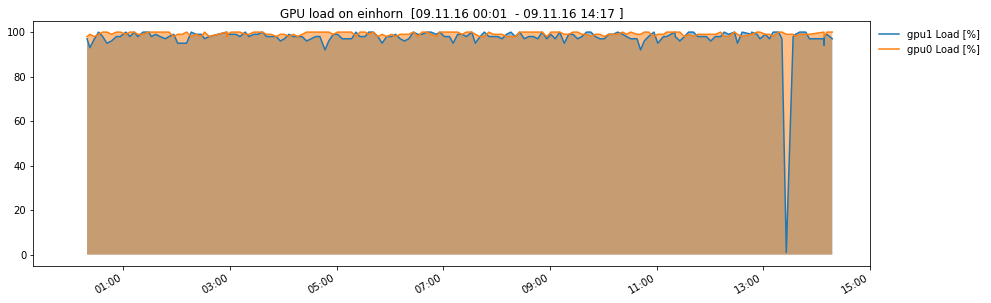

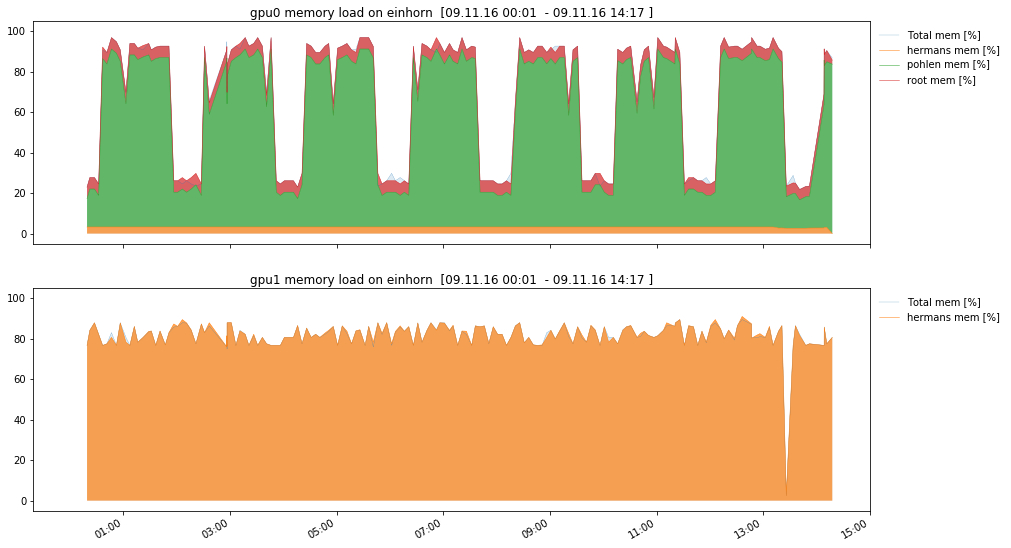

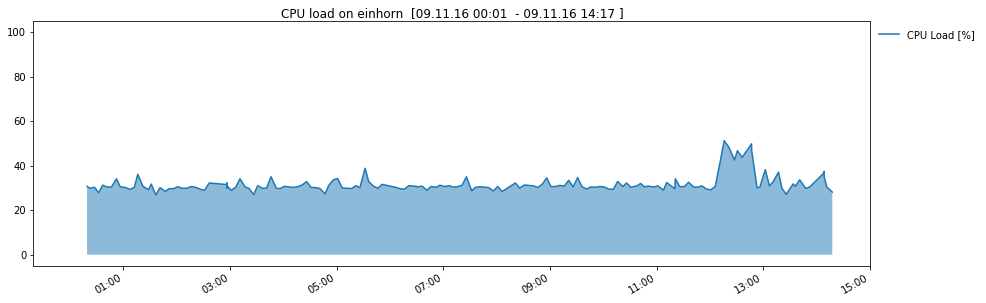

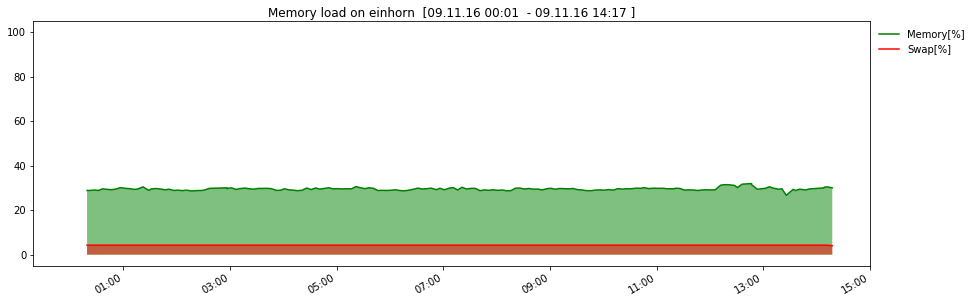

In [116]:
plot_gpu_load(data)
plot_gpu_memory_load(data)
plot_cpu_load(data)
plot_cpu_memory_load(data)

# Plotting code
* Add the max memory and swap into legend / titel.  Think about changes max etc could change!
* Multi machine plots.
* Change report across time!
* HDD info.
* Change color for non supported. http://stackoverflow.com/questions/31345489/pyplot-change-color-of-line-if-data-is-less-than-zero

In [9]:
def plot_gpu_load(data):
    machine = data[0]['machine']
    gpus = set()
    times = []
    for d in data:
        gpus.update(d.get('gpu', {}).keys())
        times.append(d['date'])
    
    xy = {}
    for g in gpus:
        xy[g] = []
    
    for d in data:
        t = d['date']
        if d.get('error', False) == False:
            for g,v in d['gpu'].items():
                xy[g].append((t,v.get('load',-4)))
        else:
            for g in gpus:
                xy[g].append((t, np.nan))

    k = list(xy.keys())
    
    fig, axes = plt.subplots(figsize=(15,5))
    axes.set_title('GPU load on {}  [{:s}  - {:s} ]'.format(machine, np.min(times).strftime("%d.%m.%y %H:%M"), np.max(times).strftime("%d.%m.%y %H:%M")))
    axes.set_ylim((-5, 105))
    
    
    for p in k:
        x, y = zip(*xy[p])
        l = axes.plot(x,y, label='{} Load [%]'.format(p))
        axes.fill_between(x,y, facecolor=l[0].get_color(), alpha=0.5)
        fig.autofmt_xdate()
    axes.legend(loc="upper left", bbox_to_anchor=(1,1))


In [10]:
def plot_cpu_load(data):
    machine = data[0]['machine']
    times = []
    for d in data:
        times.append(d['date'])
    
    xy = []
    
    for d in data:
        t = d['date']
        if d.get('error', False) == False:
            xy.append((t,d['cpu'].get('load',-4)))
        else:
            xy.append((t, np.nan))
    
    fig, axes = plt.subplots(figsize=(15,5))
    axes.set_title('CPU load on {}  [{:s}  - {:s} ]'.format(machine, np.min(times).strftime("%d.%m.%y %H:%M"), np.max(times).strftime("%d.%m.%y %H:%M")))
    axes.set_ylim((-5, 105))
    
    x, y = zip(*xy)
    l = axes.plot(x,y, label='CPU Load [%]')
    axes.fill_between(x,y, facecolor=l[0].get_color(), alpha=0.5)
    fig.autofmt_xdate()
    axes.legend(loc="upper left", bbox_to_anchor=(1,1))


In [11]:
def plot_cpu_memory_load(data):
    machine = data[0]['machine']
    times = []
    for d in data:
        times.append(d['date'])
    
    xy_mem = []
    xy_ram = []
    
    for d in data:
        t = d['date']
        if d.get('error', False) == False:
            xy_mem.append((t,d['cpu'].get('used_ram',-4)*100/d['cpu'].get('max_ram',1)))
            xy_ram.append((t,d['cpu'].get('used_swap',-4)*100/d['cpu'].get('max_swap',1)))
        else:
            xy_mem.append((t, np.nan))
            xy_ram.append((t, np.nan))
    
    fig, axes = plt.subplots(figsize=(15,5))
    axes.set_title('Memory load on {}  [{:s}  - {:s} ]'.format(machine, np.min(times).strftime("%d.%m.%y %H:%M"), np.max(times).strftime("%d.%m.%y %H:%M")))
    axes.set_ylim((-5, 105))
    
    x, y = zip(*xy_mem)
    l = axes.plot(x,y, color='green', label='Memory[%]')
    axes.fill_between(x,y, facecolor=l[0].get_color(), alpha=0.5)
    x, y = zip(*xy_ram)
    l = axes.plot(x,y, color='red', label='Swap[%]')
    axes.fill_between(x,y, facecolor=l[0].get_color(), alpha=0.5)
    fig.autofmt_xdate()
    axes.legend(loc="upper left", bbox_to_anchor=(1,1))


In [12]:
def plot_gpu_memory_load(data):
    machine = data[0]['machine']
    gpus = set()
    times = []
    for d in data:
        gpus.update(d.get('gpu', {}).keys())
        times.append(d['date'])
        
    gpus_users = {g : set() for g in list(gpus)}
        
    for d in data:
        gs = d.get('gpu', {}).keys()
        for g in gs:
            if d['gpu'][g]['proc_info_support']:
                gpus_users[g].update(set(d['gpu'][g]['proc_info'].keys()))
    
    xy = {}
    for k, v in gpus_users.items():
        xy[k] = {'total' : []}
        for u in list(v):
            xy[k][u] = []
                
    
    for d in data:
        t = d['date']
        if d.get('error', False) == False:
            for g,v in d['gpu'].items():
                max_mem = v['max_mem']
                xy[g]['total'].append((t,100.0*v['cur_mem']/max_mem))
                for u in gpus_users[g]:
                    xy[g][u].append((t,100.0*v.get('proc_info',{}).get(u,0)/max_mem))
        else:
            for g in gpus:
                xy[g]['total'].append((t,np.nan))
                for u in gpus_users[g]:
                    xy[g][u].append((t, np.nan))
    
    
    k = list(xy.keys())
    
    fig, axes = plt.subplots(len(k),1,figsize=(15,5*len(k)))
    if type(axes) is not np.ndarray:
        axes = np.asarray([axes])
    
    
    for i, g in enumerate(sorted(k)):
        axes[i].set_title('{} memory load on {}  [{:s}  - {:s} ]'.format(g, machine, np.min(times).strftime("%d.%m.%y %H:%M"), np.max(times).strftime("%d.%m.%y %H:%M")))
        axes[i].set_ylim((-5, 105))
        
        x, y = zip(*xy[g]['total'])
        l = axes[i].plot(x,y, label='Total mem [%]', lw=0.2)
        axes[i].fill_between(x,y, facecolor=l[0].get_color(), alpha=0.15)
        
        prev = 0
        mem_sum = 0*np.asarray(y) 
        for u in gpus_users[g]:
            x, y = zip(*xy[g][u])
            mem_sum += np.asarray(y)
            l = axes[i].plot(x,mem_sum, label='{} mem [%]'.format(u), lw=0.5)
            axes[i].fill_between(x,mem_sum, prev, facecolor=l[0].get_color(), alpha=0.7)
            prev = mem_sum.copy()
        fig.autofmt_xdate()
        axes[i].legend(loc="upper left", bbox_to_anchor=(1,1))
    return None
    
    for p in k:
        x, y = zip(*xy[p])
        l = axes.plot(x,y, label='{} Load [%]'.format(p))
        
    

    x, y = zip(*xy_mem)
    l = axes.plot(x,y, color='green', label='Memory[%]')
    axes.fill_between(x,y, facecolor=l[0].get_color(), alpha=0.5)
    x, y = zip(*xy_ram)
    l = axes.plot(x,y, color='red', label='Swap[%]')
    axes.fill_between(x,y, facecolor=l[0].get_color(), alpha=0.5)
    fig.autofmt_xdate()
    axes.legend(loc="upper left", bbox_to_anchor=(1,1))
